##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Note: これらのドキュメントは私たちTensorFlowコミュニティが翻訳したものです。コミュニティによる 翻訳は**ベストエフォート**であるため、この翻訳が正確であることや[英語の公式ドキュメント](https://www.tensorflow.org/?hl=en)の 最新の状態を反映したものであることを保証することはできません。 この翻訳の品質を向上させるためのご意見をお持ちの方は、GitHubリポジトリ[tensorflow/docs](https://github.com/tensorflow/docs)にプルリクエストをお送りください。 コミュニティによる翻訳やレビューに参加していただける方は、 [docs-ja@tensorflow.org メーリングリスト](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ja)にご連絡ください。

このチュートリアルでは、画像から猫または犬を分類する方法を示します。 `tf.keras.Sequential` モデルを使用して画像分類器を構築し、 `tf.keras.preprocessing.image.ImageDataGenerator` を使用してデータをロードします。このチュートリアルでは、以下のコンセプトにしたがって、実践的な経験と感覚を養います。

* `tf.keras.preprocessing.image.ImageDataGenerator` クラスを使用して _データ入力パイプライン_ を構築し、モデルで使用するディスク上のデータを効率的に処理します。
* _過学習（Overfitting）_ —過学習を識別および防止する方法。
* _データ拡張（Data Augmentation）_ および _ドロップアウト（dropout）_ —データパイプラインおよび画像分類モデルに組み込むコンピュータービジョンタスクの過学習と戦うための重要なテクニック。

このチュートリアルは、基本的な機械学習のワークフローに従います。

1. データの調査及び理解
2. 入力パイプラインの構築
3. モデルの構築
4. モデルの学習
5. モデルのテスト
6. モデルの改善とプロセスの繰り返し

## パッケージのインポート

まずは必要なパッケージをインポートすることから始めましょう。 `os`パッケージはファイルとディレクトリ構造を読み込み、 NumPy は python リストの numpy 配列への変換と必要な行列演算の実行、 `matplotlib.pyplot` はグラフの描画や学習データおよび検証データに含まれる画像の表示、に利用します。

モデルの構築に必要な TensorFlow と Keras クラスをインポートします。

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## データの読み込み

データセットのダウンロードから始めます。このチュートリアルでは、 Kaggle の <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs Cats</a> データセットをフィルタリングしたバージョンを使用します。データセットのアーカイブバージョンをダウンロードし、"/tmp/"ディレクトリに保存します。

In [5]:
#_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
#path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
#PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
PATH = os.path.join('/content/drive/MyDrive/food', 'img')

データセットのディレクトリ構造は次のとおりです:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

データの内容を抽出した後、学習および検証セットのための適切なファイルパスで変数を設定します。

In [6]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [7]:
train_cats_dir = os.path.join(train_dir, 'cats')  # 学習用の猫画像のディレクトリ
train_dogs_dir = os.path.join(train_dir, 'dogs') # 学習用の犬画像のディレクトリ
validation_cats_dir = os.path.join(validation_dir, 'cats')  # 検証用の猫画像のディレクトリ
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # 検証用の犬画像のディレクトリ

print(train_cats_dir)
print(train_dogs_dir)
print(validation_cats_dir)
print(validation_dogs_dir)

/content/drive/MyDrive/food/img/train/cats
/content/drive/MyDrive/food/img/train/dogs
/content/drive/MyDrive/food/img/validation/cats
/content/drive/MyDrive/food/img/validation/dogs


### データの理解

学習および検証ディレクトリの中にある猫と犬の画像の数を見てみましょう:

In [8]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val


In [9]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 11
total training dog images: 171
total validation cat images: 11
total validation dog images: 28
--
Total training images: 182
Total validation images: 39


便宜上、データセットの前処理およびネットワークの学習中に使用する変数を設定します。

In [57]:
batch_size = 1
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

## データの準備

モデルにデータを送る前に、画像を適切に前処理された浮動小数点テンソルにフォーマットします。

1.ディスクから画像を読み取ります。
2.これらの画像のコンテンツをデコードし、RGB値にしたがって適切なグリッド形式に変換します。
3.それらを浮動小数点テンソルに変換します。
4.ニューラルネットワークは小さな入力値を扱う方が適しているため、テンソルを0〜255の値から0〜1の値にリスケーリングします。

幸い、これらすべてのタスクは、 `tf.keras` によって提供される `ImageDataGenerator` クラスで実行できます。この `ImageDataGenerator` はディスクから画像を読み取り、適切なテンソルに前処理を行います。さらに、これらの画像をテンソルのバッチに変換するジェネレータをセットアップします。これは、ネットワーク学習時に便利です。

In [58]:
train_image_generator = ImageDataGenerator(rescale=1./255) # 学習データのジェネレータ
validation_image_generator = ImageDataGenerator(rescale=1./255) # 検証データのジェネレータ

学習および検証画像のジェネレータを定義したのち、 `flow_from_directory` メソッドはディスクから画像をロードし、リスケーリングを適用し、画像を必要な大きさにリサイズします。

In [59]:
print("Total training path:", train_dir)
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Total training path: /content/drive/MyDrive/food/img/train
Found 182 images belonging to 2 classes.


In [60]:
print("Total batch_size:", batch_size)
print("Total validation path:", validation_dir)
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Total batch_size: 1
Total validation path: /content/drive/MyDrive/food/img/validation
Found 39 images belonging to 2 classes.


### 学習用画像の可視化

学習用のジェネレータから画像バッチを抽出して可視化します。（この例では32個の画像を抽出し、そのうち5つを `matplotlib` で描画します。）

In [61]:
sample_training_images, _ = next(train_data_gen)

 `next` 関数はデータセットからバッチを返します。 `next` 関数の返り値は `（x_train、y_train）` の形式で、 `x_train` は学習用の特徴量、 `y_train` はそのラベルです。ラベルを破棄して、学習用画像の可視化のみを行います。

In [62]:
# この関数は、1行5列のグリッド形式で画像をプロットし、画像は各列に配置されます。
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

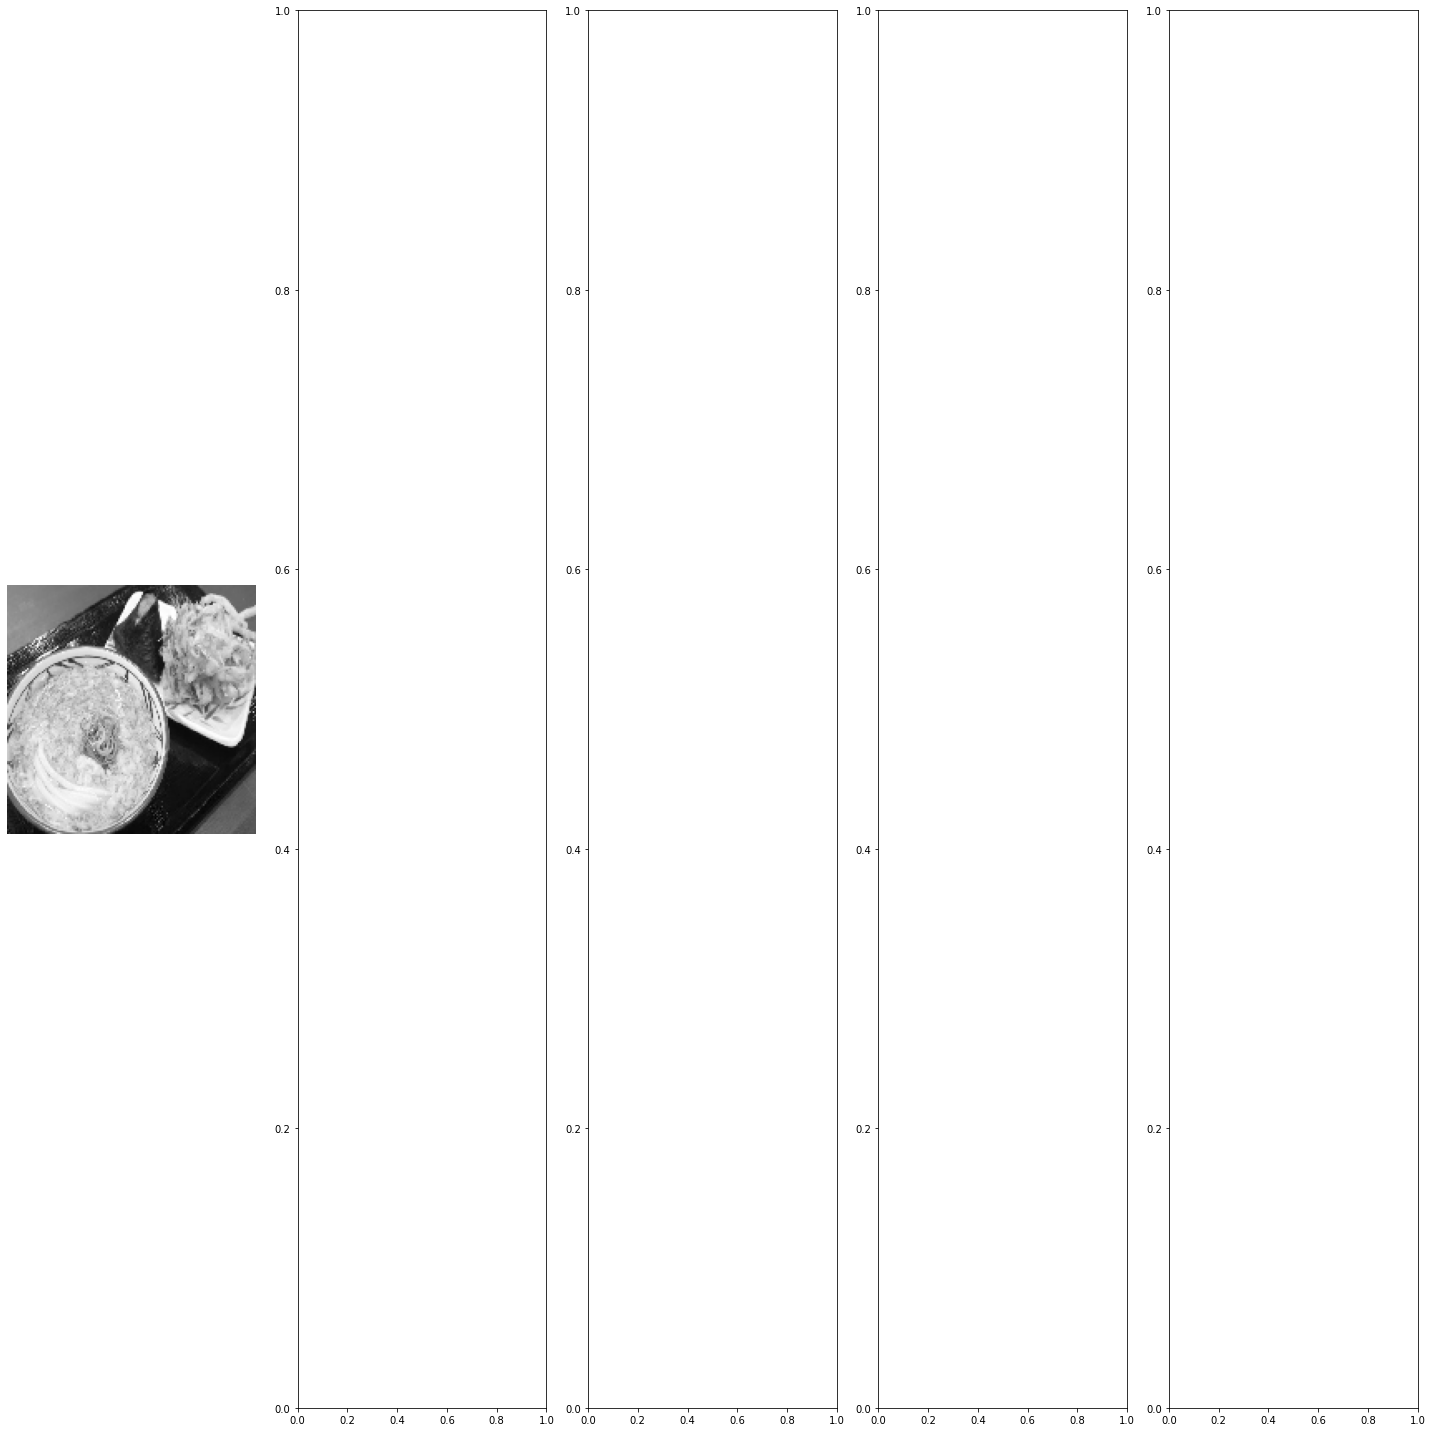

In [63]:
plotImages(sample_training_images[:5])

## モデルの構築

モデルはmax pooling層を伴う3つの畳み込みブロックからなります。さらに `relu` 活性化関数によるアクティベーションを伴う512ユニットの全結合層があります。モデルは、シグモイド活性化関数による2値分類に基づいてクラスに属する確率を出力します。

In [64]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

### モデルのコンパイル
このチュートリアルでは、 *ADAM* オプティマイザーと *binary cross entropy* 損失関数を選択します。各学習エポックの学習と検証の精度を表示するために、`metrics` 引数を渡します。

In [65]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### モデルの概要

すべてのネットワークのレイヤーを見るには、モデルの `summary` メソッドを利用します:

In [66]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 20736)            

### モデルの学習

`ImageDataGenerator` クラスの `fit_generator` メソッドを使用して、ネットワークを学習します。

In [67]:
print("val_data_gen:", val_data_gen)
print("total_val:", total_val)
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

val_data_gen: <tensorflow.python.keras.preprocessing.image.DirectoryIterator object at 0x7feaf3bc1050>
total_val: 39
Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


182/182 [==============================] - 16s 84ms/step - loss: 1.3339 - accuracy: 0.8968 - val_loss: 1.7363 - val_accuracy: 0.7179
Epoch 2/15
182/182 [==============================] - 15s 82ms/step - loss: 0.2359 - accuracy: 0.9472 - val_loss: 2.2234 - val_accuracy: 0.7179
Epoch 3/15
182/182 [==============================] - 15s 81ms/step - loss: 0.3581 - accuracy: 0.9339 - val_loss: 1.3997 - val_accuracy: 0.7179
Epoch 4/15
182/182 [==============================] - 15s 82ms/step - loss: 0.1209 - accuracy: 0.9672 - val_loss: 0.3725 - val_accuracy: 0.7179
Epoch 5/15
182/182 [==============================] - 15s 82ms/step - loss: 0.1325 - accuracy: 0.9745 - val_loss: 0.0779 - val_accuracy: 1.0000
Epoch 6/15
182/182 [==============================] - 15s 81ms/step - loss: 0.0488 - accuracy: 0.9855 - val_loss: 0.0470 - val_accuracy: 0.9744
Epoch 7/15
182/182 [==============================] - 15s 82ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0541 - val_accuracy: 0.9744
Epo

### 学習結果の可視化

ネットワークを学習した後、結果を可視化します。

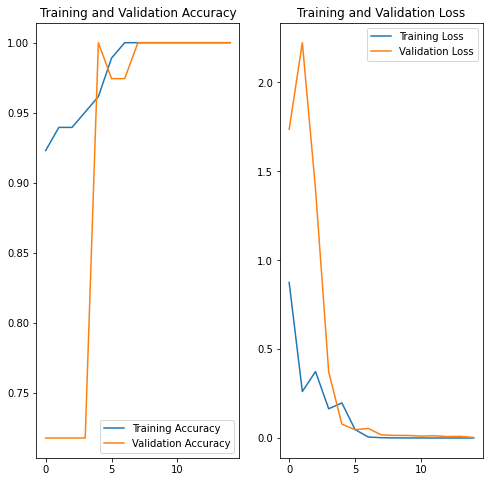

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [69]:
model.save('my_model.h5')

In [70]:
pip install tensorflowjs

In [71]:
!tensorflowjs_converter --input_format keras my_model.h5 tfjs_target

2021-03-28 13:06:07.668199: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


プロットからわかるように、学習セットの精度と検証セットの精度は大幅に外れており、モデルは検証セットで約70％の精度しか達成していません。

何がうまくいかなかったかを見て、モデル全体のパフォーマンスを向上してみましょう。

## 過学習

上記のプロットでは、学習セットの精度は時間とともに直線的に向上していますが、検証セットの精度は学習プロセスの中で約70％あたりで頭打ちになっています。そして、学習と検証の精度の違いが顕著です。これは *過学習* のサインです。

学習サンプルが少ない場合、モデルは学習サンプルに含まれるノイズや不要な詳細から学習してしまい、これによって新しいサンプルに対するモデルの性能に悪影響を与えることがあります。この現象は、過学習として知られています。過学習とは、モデルが新しいデータセットに対して汎化するのが難しい状態をいいます。

学習プロセスにおいて過学習に対抗する手段はいくつかあります。このチュートリアルでは、*データ拡張（data Augmentation）* を使用し、さらにモデルに *ドロップアウト（dropout）* を追加します。

## データ拡張（Data augmentation）

過学習は一般に、学習サンプルが少ない場合に発生します。この問題を解決する方法の1つは、十分な数の学習サンプルが含まれるようにデータセットを拡張することです。データ拡張は、既存の学習サンプルに対してランダムな変換を行い、データセットとして利用できそうな画像を生成するアプローチをとります。このデータ拡張の目的は、学習中にモデルがまったくおなじ画像を2回利用しないようにすることです。これによってモデルをデータのより多くの特徴を利用し、より汎化することができます。

`tf.keras` においては、このデータ拡張を `ImageDataGenerator` クラスを使用して実装します。データセットに対するさまざまな変換を指定することによって、学習プロセス中にそれが適用されます。

### データの拡張と可視化

最初に、ランダムな水平反転による拡張をデータセットに適用し、それぞれの画像が変換後にどのように見えるかを確認します。

### 水平反転の適用

 このデータ拡張を適用するためには、 `ImageDataGenerator` クラスの引数として `horizontal_flip` を渡し、 `True`を設定します。

In [72]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [73]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 182 images belonging to 2 classes.


学習サンプルから1つのサンプル画像を取得する作業を5回繰り返して、おなじ画像に5回データ拡張が適用されるようにします。

In [74]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

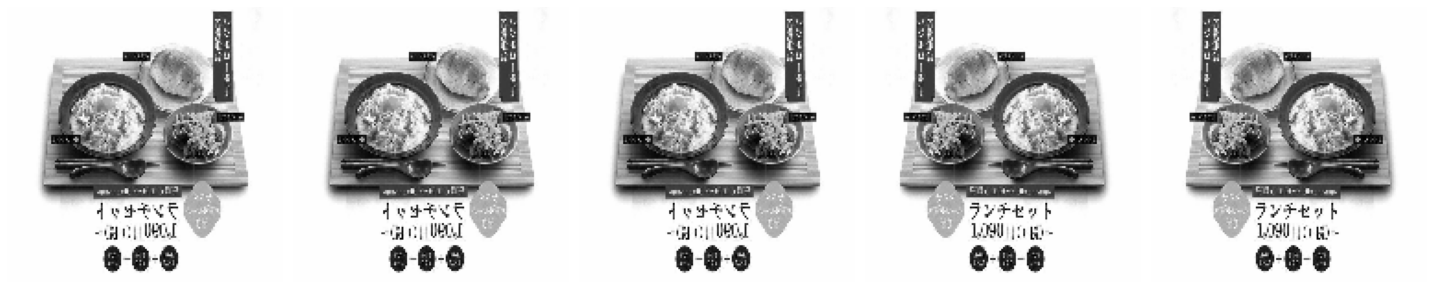

In [75]:
# 上で学習用画像の可視化のために定義、使用されたおなじカスタムプロット関数を再利用する
plotImages(augmented_images)

### 画像のランダムな回転

回転のデータ拡張を利用して学習用サンプルをランダムに左右45度の範囲で回転させてみましょう。

In [76]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [77]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 182 images belonging to 2 classes.


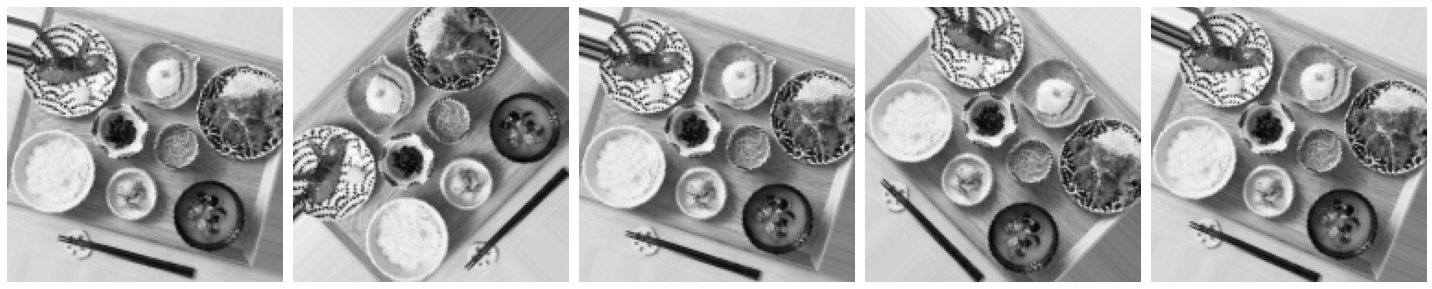

In [78]:
plotImages(augmented_images)

### ズームによるデータ拡張の適用

データセットにズームによるデータ拡張を適用して、画像をランダムに最大50％拡大します。

In [79]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

In [80]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 182 images belonging to 2 classes.


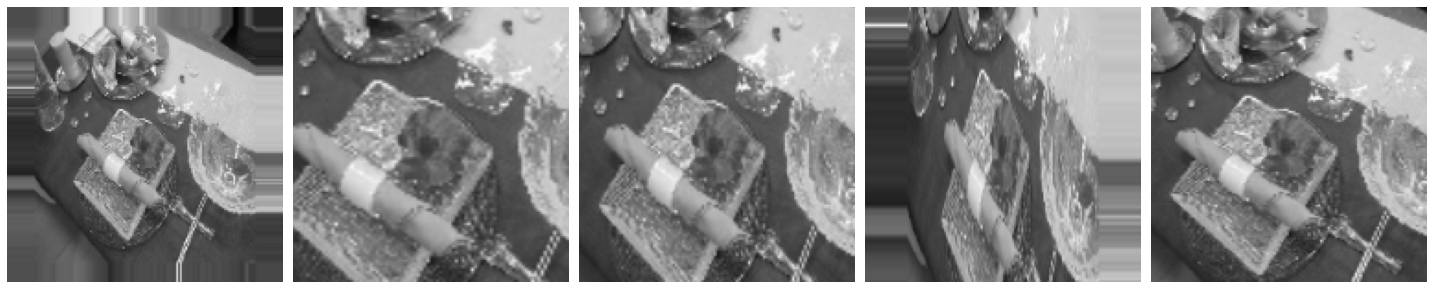

In [81]:
plotImages(augmented_images)

### すべてのデータ拡張を同時に利用する

ここまでで紹介したすべてのデータ拡張機能を適用します。ここでは、学習用画像に対して、リスケール、45度の回転、幅シフト、高さシフト、水平反転、ズームを適用しました。

In [82]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [83]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 182 images belonging to 2 classes.


これらのデータ拡張がデータセットにランダムに適用されたときに、一つの画像に対して5回の個別の適用を行った際にそれぞれどのように見えるかを可視化します。

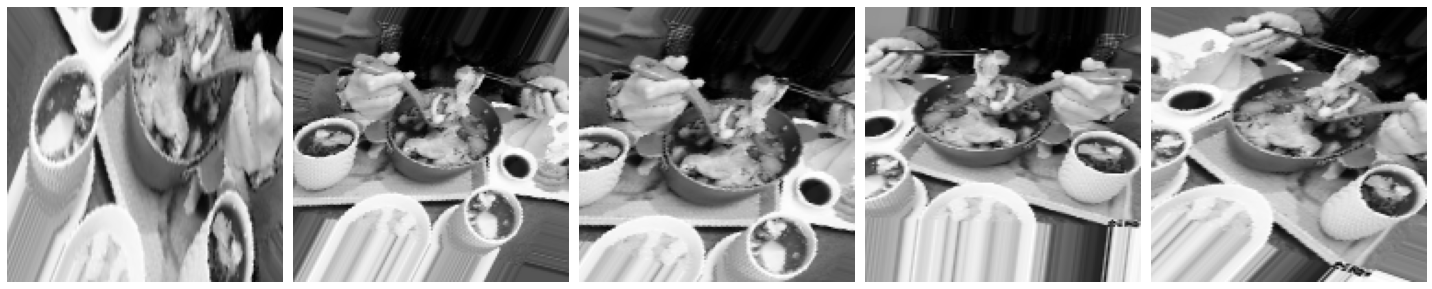

In [84]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### 検証データジェネレータの構築

一般に、データ拡張は学習サンプルのみに適用します。今回は、 `ImageDataGenerator` を使用して検証画像に対してリスケールのみを実施し、バッチに変換します。

In [85]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [86]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 39 images belonging to 2 classes.


## ドロップアウト（dropout）

過学習を避けるもう一つの方法は、ネットワークに *ドロップアウト* を導入することです。これは、ネットワークにおいて重みを小さくする正則化の方式で、これによって重みの値の分布がより規則的になり、少ない学習データに対する過学習を減らすことができます。ドロップアウトはこのチュートリアルで利用される正則化手法の一つです。

ドロップアウトをレイヤーに適用すると、学習プロセス中に適用されたレイヤーのうちランダムに出力ユニットをドロップアウト（ゼロに設定）します。ドロップアウトは、入力値として0.1、0.2、0.4といった形式の小数をとります。これは、適用されたレイヤーからランダムに出力単位の10％、20％、または40％をドロップアウトすることを意味します。

特定のレイヤーに0.1ドロップアウトを適用すると、各学習エポックにおいて出力ユニットの10％がランダムに0にされます。

この新しいドロップアウト機能を使用したネットワークアーキテクチャを作成し、異なる畳み込みレイヤーや全接続レイヤーに適用してみましょう。

## ドロップアウトを追加した新しいネットワークの構築

ここでは、ドロップアウトを最初と最後の max pool 層に適用します。ドロップアウトを適用すると、各学習エポック中にニューロンの20％がランダムにゼロに設定されます。これにより、学習データセットに対する過学習を避けることができます。

In [87]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

### モデルのコンパイル

ネットワークにドロップアウトを導入した後、モデルをコンパイルし、レイヤーの概要を表示します。

In [88]:
model_new.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_new.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 18, 64)       

### モデルの学習

学習サンプルにデータ拡張を導入し、ネットワークにドロップアウトを追加した後、この新しいネットワークを学習します:

In [89]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
182/182 [==============================] - 17s 90ms/step - loss: 1.5692 - accuracy: 0.8734 - val_loss: 0.6052 - val_accuracy: 0.7179
Epoch 2/15
182/182 [==============================] - 16s 88ms/step - loss: 0.2820 - accuracy: 0.9363 - val_loss: 1.4131 - val_accuracy: 0.7179
Epoch 3/15
182/182 [==============================] - 16s 88ms/step - loss: 0.3867 - accuracy: 0.9552 - val_loss: 0.6037 - val_accuracy: 0.7179
Epoch 4/15
182/182 [==============================] - 16s 87ms/step - loss: 0.3033 - accuracy: 0.9222 - val_loss: 3.3704 - val_accuracy: 0.7179
Epoch 5/15
182/182 [==============================] - 16s 88ms/step - loss: 0.2308 - accuracy: 0.9509 - val_loss: 0.8021 - val_accuracy: 0.7179
Epoch 6/15
182/182 [==============================] - 16s 87ms/step - loss: 0.2421 - accuracy: 0.9352 - val_loss: 0.7845 - val_accuracy: 0.7179
Epoch 7/15
182/182 [==============================] - 16s 86ms/step - loss: 0.2384 - accuracy: 0.9315 - val_loss: 0.4918 - val_accuracy:

### モデルの可視化

学習後に新しいモデルを可視化すると、過学習が前回よりも大幅に少ないことがわかります。より多くのエポックでモデルを学習すると、精度はさらに向上するはずです。

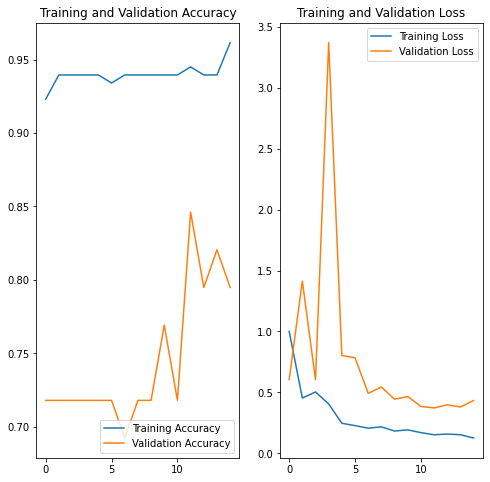

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [91]:
model_new.save('new_my_model.h5')

In [92]:
pip install tensorflowjs

In [93]:
!tensorflowjs_converter --input_format keras new_my_model.h5 new_tfjs_target

2021-03-28 13:11:44.104466: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
